# Imports

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
from tqdm.notebook import tqdm
from skimage.color import rgb2lab, lab2lch, lab2rgb, lch2lab
import cv2
import OpenEXR
import Imath
import math
from scipy.ndimage import rotate
from sklearn.preprocessing import minmax_scale
from findpeaks import findpeaks
from skimage import transform
import copy

from matplotlib import pyplot as plt
from matplotlib.offsetbox import OffsetImage,AnnotationBbox

import torch
from torch import nn

# Functions

## Reading image

#### Cutting image middle N

In [2]:
# image - image to crop
# N - size of both sides of the new image (it will be a square)
# returns cropped image
def cut_image_middle_N(image, N):
    # Checking conditions for N
    if N > image.shape[0] or N > image.shape[1] or N < 0:
        print("Error: N is wrong.")
        return None
    
    # Calculating the middle
    middle = (int(math.floor(image.shape[0]/2)), int(math.floor(image.shape[1]/2)))
    N_half = math.floor(N/2)
    
    # Cutting the image in 2 or 3 dimensions
    if len(image.shape) == 2:
        image_cut = image[middle[0]-N_half:middle[0]+N_half, middle[1]-N_half:middle[1]+N_half]
    elif len(image.shape) == 3:
        image_cut = image[middle[0]-N_half:middle[0]+N_half, middle[1]-N_half:middle[1]+N_half, :]
    else:
        print("Error: Image dimension needs to be 2 or 3")
        return None
    
    return image_cut

In [3]:
# image - image to crop
# width - new width
# heigth - new height
# returns cropped image
def cut_image_middle_W_H(image, width, height):
    # Checking conditions for N
    if height > image.shape[0] or width > image.shape[1] or height < 0 or width < 0:
        print("Error: N is wrong.")
        return None
    
    # Calculating the middle
    middle = (int(math.floor(image.shape[0]/2)), int(math.floor(image.shape[1]/2)))
    height_half = math.floor(height/2)
    width_half = math.floor(width/2)
    
    # Cutting the image in 2 or 3 dimensions
    if len(image.shape) == 2:
        image_cut = image[middle[0]-height_half:middle[0]+height_half, middle[1]-width_half:middle[1]+width_half]
    elif len(image.shape) == 3:
        image_cut = image[middle[0]-height_half:middle[0]+height_half, middle[1]-width_half:middle[1]+width_half, :]
    else:
        print("Error: Image dimension needs to be 2 or 3")
        return None
    
    return image_cut

#### Cut image every N

In [4]:
# image - image to crop
# N - function takes every Nth pixel of the image in both first axes
# returns cropped image
def cut_image_every_N(image, N):
    if len(image.shape) == 2:
        image_cut = image[1::N, 1::N]
    elif len(image.shape) == 3:
        image_cut = image[1::N, 1::N, :]
    else:
        print("Error: Image dimension needs to be 2 or 3")
        return None
    return image_cut

#### Skew image
(photos should already be skewed, used only to artificially skew BTF images)

In [5]:
def skew_image(image_1, angle):
    # Translation matrix to shift the image center to the origin
    r, c = image_1.shape[0:2]
    T = np.array([[1, 0, -c / 2.],
                  [0, 1, -r / 2.],
                  [0, 0, 1]])

    # Skew, for perspective
    S = np.array([[1, 0, 0],
                  [0, np.cos(np.deg2rad(angle)), 0],
                  [0, 0, 1]])

    tform = transform.ProjectiveTransform(matrix=S.dot(np.linalg.inv(T).dot(np.eye(3,3)).dot(T)))
    tf_img = transform.warp(image_1, tform.inverse)
    new_height = int(r*np.cos(np.deg2rad(45)))
    tf_img = tf_img[0:new_height, :, :]
    return tf_img

#### Opening video file to RGB

In [6]:
def open_vid_image(path):
    # Reading image
    image = cv2.imread(path)
    # Converting BGR input to RGB image
    image = image[...,::-1]
    return image

#### Opening EXR file to RGB

In [7]:
# filePath - path to EXR image file
# CROPP - cropping method - "middle" for crop around middle or "every" for sampling every Nth pixel
# N - parameter for cropping methods
# returns EXR file as numpy array, cropped if specified
def open_EXR(filePath, CROPP=None, N=None):
    # Definitions
    IMATH_FLOAT = Imath.PixelType(Imath.PixelType.FLOAT)

    # Opening EXR file, saving header data
    imageEXR = OpenEXR.InputFile(filePath)
    imageEXR_head = imageEXR.header()
    

    # Extracting size from header
    im_dW = imageEXR_head['dataWindow']
    imageEXR_size = (im_dW.max.y - im_dW.min.y + 1, im_dW.max.x - im_dW.min.x + 1)
    
    # Extracting channels
    def get_channel(exrfile, channel):
        raw_bytes = exrfile.channel(channel, IMATH_FLOAT)
        data = np.frombuffer(raw_bytes, dtype=np.float32)
        return data
    data = [get_channel(imageEXR, c).reshape(imageEXR_size) for c in 'RGB']
    image = np.dstack(data)
    
    if CROPP == "middle":
        image = cut_image_middle_N(image, N)
    if CROPP == "every":
        image = cut_image_every_N(image, N)
        
    image_size = image.shape
    
    # Conversion matrix for color spaces conversion CIE XYZ -> sRGB
    conv_matrix = np.matrix([[3.2404542, -1.5371385, -0.4985314],
                   [-0.9692660, 1.8760108, 0.0415560],
                   [0.0556434, -0.2040259, 1.0572252]])
    
    # Convert image using matrix multiplication
    image = image.reshape((image_size[0] * image_size[1], 3))
    new_array = image * np.transpose(conv_matrix)
    new_array = np.asarray(new_array).reshape((image_size[0], image_size[1], 3))
    
    # Modifing values to range [0...1], dividing and clipping to <0,1> interval
    new_array_smaller = new_array / 100
    new_array_smaller = np.clip(new_array_smaller, 0, 1)

    # Gamma modification sRGB' to sRGB
    new_array_smaller = np.where(new_array_smaller <= 0.0031308, 12.92 * new_array_smaller, 1.055 * np.power(new_array_smaller, 1 / 2.4) - 0.055)
    
    return new_array_smaller

#### Transfering color spaces

In [8]:
# from_space - color space to convert from - works for RGB, LAB, LCH
# to_space - color space to convert to - works for RGB, LAB, LCH
def transfer_color_space(image, from_space, to_space):
    if from_space.lower() == "rgb":
        if to_space.lower() == "lch":
            image = rgb2lab(image, "D65")
            image = lab2lch(image)
            return image
        elif space.lower() == "lab":
            image = rgb2lab(image, "D65")
            return image
        else:
            print("Error: To space LAB or LCH")
            return None
    elif from_space.lower() == "lab":
        if to_space.lower() == "lch":
            image = lab2lch(image)
            return image
        elif space.lower() == "rgb":
            image = lab2rgb(image)
            return image
        else:
            print("Error: To space RGB or LCH")
            return None
    elif from_space.lower() == "lch":
        if to_space.lower() == "lab":
            image = lch2lab(image)
            return image
        elif space.lower() == "rgb":
            image = lch2lab(image)
            image = lab2rgb(image)
            return image
        else:
            print("Error: To space RGB or LAB")
            return None
    else:
        print("Error: From space RGB, LAB or LCH")
        return None

## Computing statistics

#### Prepare image for statistic computation - TRAIN VIDEO DATA

In [9]:
def prepare_image_train(image):
    # Proportional height computation
    r = FOURIER_SIZE / float(image.shape[0])
    dim = (int(image.shape[1] * r), FOURIER_SIZE)
    # Resize HEIGHT to FOURIER_SIZE
    image = cv2.resize(image, dim, interpolation=cv2.INTER_NEAREST)
    # Cut the middle FOURIER_SIZE
    image = cut_image_middle_N(image, FOURIER_SIZE)
    return image

#### Prepare image for statistic computation - BTF

In [10]:
def prepare_image_btf_dpi(image, DPI):
    # Compute new width and height based on desired real size and DPI
    new_width = TRAIN_REAL_SIZE/((1/DPI) * IN2MM)
    # Height is prepared for skewing to 45 degrees - larger
    new_height = (TRAIN_REAL_SIZE*np.sqrt(2))/((1/DPI) * IN2MM)
    
    if new_height > image.shape[0]:
        # Proportional height computation
        r = new_height / float(image.shape[0])
        dim = (int(image.shape[1] * r), int(np.ceil(new_height)))
        # Resize HEIGHT to FOURIER_SIZE
        image = cv2.resize(image, dim, interpolation=cv2.INTER_NEAREST)
    
    # Cut image around middle
    image = cut_image_middle_W_H(image, new_width, new_height)
    return image

#### Prepare image for statistic computation - PHOTO WITH SIZE

In [11]:
def prepare_image_photo_middle(image, real_width):
    # Calculate new width based on real width of given photo
    # Transforms the photo sample to be the same real size as the training frames
    new_width = (TRAIN_REAL_SIZE * image.shape[1]) / real_width
    if new_width <= image.shape[1]:
        # Cut the middle part to be the appropriate size
        image = cut_image_middle_N(image, new_width)
    # Resample to FOURIER_SIZE
    image = cv2.resize(image, dsize=(FOURIER_SIZE, FOURIER_SIZE), interpolation=cv2.INTER_NEAREST)
    return image

#### Preparing image for Fourier transform 
(photo should already be cropped - useless, but still useful for selecting the first channel)

In [12]:
# image - image to preprocess
# returns square image size SIZE with one channel
def prepare_image_for_fourier(image, SIZE):
    image_cut = cut_image_middle_N(image, SIZE)
    # Fourier transform requires only one channel
    if len(image.shape) > 2 :
        image_cut = image_cut[:, :, 0]
    return image_cut

#### Count PSD spectrum

In [13]:
# image - image to count PSD of, needs to be a square, best is power of 2
# returns the binned frequency values, binned amplitude values
def count_only_psd(image):
    # Size of image
    npix = image.shape[0]
    # Fourier transform
    fourier_image = np.fft.fftn(image)
    # Getting the amplitudes as one number from complex numbers
    fourier_amplitudes = np.abs(fourier_image)**2
    # Getting corresponding frequencies
    kfreq = np.fft.fftfreq(npix) * npix
    kffreq2D = np.meshgrid(kfreq, kfreq)
    knrm = np.sqrt(kffreq2D[0]**2 + kffreq2D[1]**2)
    # Flattening the data to 1D array
    knrm = knrm.flatten()
    fourier_amplitudes = fourier_amplitudes.flatten()
    # Setting up bins
    kbins = np.arange(0.5, npix//2+1, 1.)
    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    # Binning the values of amplitudes
    Abins, _, _ = sp.stats.binned_statistic(knrm, fourier_amplitudes, statistic="mean", bins=kbins)
    # Muliplying by space of the bin
    Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
    return kvals, Abins

#### Count mean of low, middle and high frequencies

In [14]:
# image - image to count mean frequency of
# borders - list of borders between which the mean of the frequency will be computed
# returns a list of means of amplitudes of frequencies between borders
def count_freq(image, borders):
    mean_all = []
    # Cutting image around the middle
    # Needs to be square and best is a power of 2
    image_cut = prepare_image_for_fourier(image, FOURIER_SIZE)
    # Getting the PSD
    kvals, Abins = count_only_psd(image_cut)
    # Iterating through the area set by borders
    for i in range(len(borders)-1):
        # Calculating the mean of the amplitudes between borders
        mean_all.append(np.mean(Abins[borders[i]:borders[i+1]]))
    return mean_all

#### Image of the Fourier transform spectrum

In [15]:
# image - image from which to get amplitude spectrum by Fourier transform, only 1 channel and square size
# returns values of amplitudes in the size of the original image
def count_fourier_image(image):
    # Image must be a square size
    if image.shape[0] != image.shape[1]:
        print("Image must have same width and height")
        return None
    # Size of image
    npix = image.shape[0]
    # Fourier transform
    fourier_image = np.fft.fftn(image)
    # Getting the amplitudes as one number from complex numbers
    fourier_amplitudes = np.abs(fourier_image)**2
    # Shifting amplitude spectrum so low frequencies are in the middle
    # Getting the log of the data for better plotting
    return np.fft.fftshift(fourier_amplitudes)

#### Getting the circular sector

In [16]:
# Function from
# https://stackoverflow.com/questions/18352973/mask-a-circular-sector-in-a-numpy-array

# shape - shape of the original image to mask
# centre - tuple of centre coordinates of the circle to mask (middle of the image)
# radius - size of the circle to mask
# angle_range - tuple of range of the circle
# returns mask of the specified parameters
def sector_mask(shape,centre,radius,angle_range):
    x,y = np.ogrid[:shape[0],:shape[1]]
    cx,cy = centre
    tmin,tmax = np.deg2rad(angle_range)
    # ensure stop angle > start angle
    if tmax < tmin:
            tmax += 2*np.pi
    # convert cartesian --> polar coordinates
    r2 = (x-cx)*(x-cx) + (y-cy)*(y-cy)
    theta = np.arctan2(x-cx,y-cy) - tmin
    # wrap angles between 0 and 2*pi
    theta %= (2*np.pi)
    # circular mask
    circmask = r2 <= radius*radius
    # angular mask
    anglemask = theta <= (tmax-tmin)
    return circmask*anglemask

#### Computing mean values in different parts of the Fourier spectrum

In [17]:
# image - image to compute, must have only 1 channel and be prepared for Fourier transform size-wise
# sectors_num - number of circular sections to divide the image into, computed only on half of them
# cir_num - number of circles to divide the image into
# start_num - starting angle for the sectors - set to 270 to start at the top
# returns means of given areas and the size of the areas
def mean_circular_sectors_cut(image_cut, sectors_num, cir_num, start_num=270):
    # Setting up the containers, only half of the image is used - sectors are divided by 2
    mean_all = np.zeros((cir_num, math.ceil(sectors_num/2)))
    sum_all = np.zeros((cir_num, math.ceil(sectors_num/2)))
    
    # Size of 1 sector in angles
    sector_size = int(360/sectors_num)
    
    # Iterate through half of the sectors
    for i in range(math.ceil(sectors_num/2)):
        # Iterate through dividing circles
        for j in range(cir_num):
            # Compute the amplitude spectrum
            fourier = count_fourier_image(image_cut)
            
            # Find the middle of the image
            middle = (int(math.floor(fourier.shape[0]/2)), int(math.floor(fourier.shape[1]/2)))
            
            # Getting the big mask that the smaller will be subtracted from to create areas between two circles
            # The size of the circle is size of the image divided by the number of the circles
            if j != (cir_num-1):
                big_size = math.floor(middle[0]/cir_num)*(j+1)
            # The last circle is the whole image - circle is the size of the image
            else:
                big_size = middle[0]
            big_mask = sector_mask(fourier.shape, (middle[0], middle[1]), big_size, (start_num+i*sector_size, (start_num+sector_size)+i*sector_size))
            
            # Getting the small mask that will be subtracted from the bigger to create areas between two circles
            small_size = math.floor(middle[0]/cir_num)*(j)
            small_mask = sector_mask(fourier.shape, (middle[0], middle[1]), small_size, (start_num+i*sector_size, (start_num+sector_size)+i*sector_size))
            
            # Masking the image - area of the big mask is the only left, then the small mask is subtracted
            # Big mask - in
            fourier[~big_mask] = 0
            # Small mask - out
            fourier[small_mask] = 0
            
            # Mean of the selected area
            mean_mask = fourier > 0
            mean_all[j,i] = np.mean(fourier[mean_mask])
            
            # Size of the area
            sum_all[j,i] = np.sum(mean_mask, axis=(0, 1))
            
    return mean_all, sum_all

#### Calculating directionality

In [18]:
def count_directionality_cut(mean_all_mult):
    # Number of columns - of sections
    n = mean_all_mult.shape[1]
    # Get sum of the columns
    all_sum = np.sum(mean_all_mult, axis=0)
    # Select the maximum column values
    max_col = np.max(all_sum)
    # Count the directionality
    direct = np.sum(max_col - all_sum)/(n * max_col)

    return direct

#### Calculating pattern strength

In [19]:
def count_pattern_str(means_mult):
    # Compute mean of columns - info about the whole sector of Fourier from center to edge - through all frequencies
    means = np.mean(means_mult, axis=0)
    # Find the maximum
    maxim = np.argmax(means)
    ratio = []
    for i in range(len(means)):
        if i != maxim:
            # Compute the ratio between the sector and the max value sector
            ratio.append(means[maxim]/means[i])
    # Mean of the ratios - how on average is the value different from the max
    return np.mean(ratio)

#### Calculating pattern directions

In [20]:
def count_pattern(image):   
    # Prepare image for Fourier transform (cut and select first channel)
    image_cut = prepare_image_for_fourier(image, FOURIER_SIZE)
    # Compute the Fourier image sectors - their mean values and sizes
    means, sums = mean_circular_sectors_cut(image_cut, SECTORS, CIRCLES)
    # Multiply the means by the size of the sector
    means_mult = np.multiply(means, sums)
    
    # Directionality computation
    direct = count_directionality_cut(means_mult)
    
    # Pattern stregth computation
    patt_str = count_pattern_str(means_mult)
    
    # Pattern number computation
    # Compute sum of columns - info about the whole sector of Fourier from center to edge - through all frequencies
    all_sum = np.sum(means_mult, axis=0)
    # Scaling to (0,1) - just need information about peaks not their size
    all_sum_red = minmax_scale(all_sum)
    # Find peaks
    fp = findpeaks(method="topology", verbose=0)
    local_max = fp.fit(all_sum_red)
    # Peaks values
    peaks = local_max["persistence"][["y", "score"]].values
    # Select only the important peaks - higher score than 0.5
    peaks_new = [i[0] for i in peaks if i[1] > 0.5]
    # If both peaks at the ends are found, the end one is deleted - ensures the "circle" nature, connect them into one peak
    if 0 in peaks_new and 11 in peaks_new:
        peaks_new.remove(11)
        
    return direct, len(peaks_new), patt_str

#### Calculating multicolored

In [21]:
def count_multicolored(image):
    # 1 - A color channel
    # 2 - B color channel
    src_X = image[:, :, 1].flatten()
    src_Y = image[:, :, 2].flatten()
    
    # Calculating color space data as a 2D histogram
    Z, xedges, yedges = np.histogram2d(src_X, src_Y, bins=[np.linspace(-128, 128, 129), np.linspace(-128, 128, 129)], weights=image[:, :, 0].flatten())
    
    # Finding peaks in the 2D histogram
    # Important parameter "limit", to limit the score of peaks - suppresses noise
    fp = findpeaks(limit=30, verbose=0)
    local_max = fp.fit(Z)
    
    # Return number of peaks for image
    return (len(local_max["persistence"][["x", "y"]].values))

#### All statistics computation

In [22]:
def all_stats_one_image(image):
    # Read image into LCH color space
    image = transfer_color_space(image, "rgb", "lch")

    COL=0
    COL_CHR=1
        
    # Maximum - 99 percentile
    max_val = np.percentile(image[:, :, COL], 99, axis=(0, 1))
    # Minimum - 1 percentile
    min_val = np.percentile(image[:, :, COL], 1, axis=(0, 1))
    # Mean
    mean_val = np.mean(image[:, :, COL], axis=(0, 1))
    # Variance
    var_val = np.var(image[:, :, COL], axis=(0, 1))
    # Skewness
    ske_val = sp.stats.skew(image[:, :, COL], axis=(0, 1))
    # Kurtosis
    kur_val = sp.stats.kurtosis(image[:, :, COL], axis=(0, 1))
    # Frequency analysis by PSD spectrum - BORDERS separate low, middle, high
    freq_tmp = count_freq(image[:, :, COL], BORDERS)
    freq_low = freq_tmp[0]
    freq_mid = freq_tmp[1]
    freq_high = freq_tmp[2]
    # Pattern information computation
    tmp = count_pattern(image[:, :, COL])
    # Directionality
    dir_val = tmp[0]
    # Pattern number
    pattern_num_val = tmp[1]
    # Pattern strength
    pattern_str_val = tmp[2]
    # Mean chroma - weighted by luminance
    mean_val_chr = np.mean((image[:, :, COL] * image[:, :, COL_CHR]), axis=(0, 1))
        
    # Read image into LAB color space
    image = transfer_color_space(image, "lch", "lab")
    # Number of colors
    multicolor_val = count_multicolored(image)
    
    return np.array([max_val, min_val, mean_val, var_val, ske_val, kur_val, dir_val, 
                    freq_low, freq_mid, freq_high, 
                    mean_val_chr, pattern_str_val, pattern_num_val, multicolor_val])

## Plotting and printing

In [23]:
# Plotting 2 images used for computation - non-specular and specular
def plot_images(image_1, image_2):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].imshow(image_1)
    ax[0].set_title("Image non-specular")
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].imshow(image_2)
    ax[1].set_title("Image specular")
    plt.show()

In [24]:
# Printing stats computed
def print_stats(stats, names):
    df = pd.DataFrame(stats, columns=STAT_NAMES).round(2)
    df.index = names
    display(df)

In [25]:
# Printing results
def print_res(stats, ranks=None, names=None):
    df = pd.DataFrame(stats, columns=RATING_NAMES).round(4)
    df = df.append(ranks)
    df.index = names
    display(df)

In [26]:
# Plotting results as a line graph
def plot_res(data, colors=["blue", "red", "tab:green"], labels=["Original", "Predicted VIDEO", "Predicted BTF"]):
    plt.figure(figsize=(15, 8))
    for i in range(len(data)):
        plt.plot(RATING_NAMES, data[i], color=colors[i], marker="o", label=labels[i])
    plt.legend()
    plt.grid(alpha=0.5)
    plt.xticks(rotation=90)
    plt.ylim(-2.5, 2.5)
    plt.yticks(np.arange(-2.5, 3, 0.5))
    plt.show()

In [29]:
# Plotting differences between ratings and predictions for VIDEO and EXR predictions
# With images for training materials
def plot_res_miss_images(miss_vid, miss_exr, MAT_NAMES, STAT_NAME, images):
    fig, ax = plt.subplots(figsize=(20, 5))
    N = len(MAT_NAMES)
    ind = np.arange(N)
    width = 0.5
        
    bars = ax.bar(ind, miss_vid , width, label='Video', color="red")
    ax.bar_label(bars, padding=3, fmt="%.3f")
    bars = ax.bar(ind + width, miss_exr, width, label='BTF', color="tab:green")
    ax.bar_label(bars, padding=3, fmt="%.3f")
        
    ax.grid(alpha=0.5)
    ax.set_xlabel('Materials')
    ax.set_ylabel("Prediction difference")
    ax.set_title("Prediction differences for selected materials - " + STAT_NAME)

    plt.ylim(-2.5, 2.5)
    
    ax.set_xticks(ind + width / 2, (MAT_NAMES))
    ax.tick_params(axis='x', which='major', pad=30)
    
    # Images as the X ticks
    for i, c in enumerate(MAT_NAMES):
        im = OffsetImage(images[i], zoom=0.1)
        im.image.axes = ax
        ab = AnnotationBbox(im, (i+0.25, -2.5), xybox=(0., -5.), frameon=False, xycoords="data", boxcoords="offset points", pad = 0)
        ax.add_artist(ab)
    
    ax.legend(loc='best')
    plt.show()

In [30]:
# Plotting mean difference through all statistics for each material
def plot_mean_miss(miss_vid, miss_exr, RATING_NAMES):
    plt.figure(figsize=(20, 5))
    N = len(RATING_NAMES)
    ind = np.arange(N)
    width = 0.45
        
    bars = plt.bar(ind, miss_vid , width, label='Video', color="red")
    plt.bar_label(bars, padding=3, fmt="%.3f")
    bars = plt.bar(ind + width, miss_exr, width, label='BTF', color="tab:green")
    plt.bar_label(bars, padding=3, fmt="%.3f")
        
    plt.grid(alpha=0.5)
    plt.xlabel('Rating dimensions')
    plt.ylabel("Mean absolute difference")
    plt.title("Mean prediction differences for selected materials")
    
    plt.ylim(0, 1)
    
    plt.xticks(ind + width / 2, (RATING_NAMES))
    plt.xticks(rotation=90)
    
    plt.legend(loc='best')
    plt.show()

In [31]:
# General function for showing images
def show_images(images):
    fig, ax = plt.subplots(1, len(images), figsize=(20, 3))
    plt.subplots_adjust(wspace=0, hspace=0)
    for i in range(len(images)):
        ax[i].imshow(images[i])
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].set_axis_off()

In [92]:
# Polar plot
# data_all_old - array of values to plot
# RATINGS - names of rating statistics (generally RATING_NAMES is used)
# COLORS - color for each data in the array
# LABELS - legend lables for each data
# order - ordering of the RATINGS stats, index array for numpy array rearrangement
# save - path to save the image to
# noticks - True for version without ticks
def polar_plot(data_all_old, RATINGS, COLORS, LABELS=None, title=None, order=None, save=None, noticks=False):
    # Rearranging order
    data_all = copy.deepcopy(data_all_old)
    if order is not None:
        for i in range(len(data_all)):
            data_all[i] = data_all[i][order]
        RATINGS = np.array(RATINGS)[order]
    
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, polar=True)
    theta = np.linspace(0, 2 * np.pi, len(RATINGS), endpoint=False)
    theta = np.concatenate((theta, [theta[0]]))
    
    # Black circle around 0
    ax.fill_between(np.linspace(0, 2*np.pi, 100), -0.005, 0.005, color='black', zorder=10, linestyle=":")
    
    # Data plotting
    for idx, data in enumerate(data_all):
        data = np.concatenate((data, [data[0]]))
        if LABELS is not None:
            ax.plot(theta, data, marker="o", color=COLORS[idx], label=LABELS[idx])
        else:
            ax.plot(theta, data, marker="o", color=COLORS[idx])
        ax.fill(theta, data, color=COLORS[idx], alpha=0.05)

    theta = np.linspace(0, 2 * np.pi, len(RATINGS), endpoint=False)
    ax.set_thetagrids((theta * 180/np.pi), RATINGS, fontsize=12)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(direction='clockwise')
    
    # Positioning the labels around the circle
    for label, theta in zip(ax.get_xticklabels(), theta):
        if theta in (0, np.pi):
            label.set_horizontalalignment('center')
        elif 0 < theta < np.pi:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')
    
    ax.set_ylim(-2.5, 2.5)
    ax.tick_params(axis="y", labelsize=15)
    ax.tick_params(axis="x", labelsize=15)
    ax.set_rlabel_position(180 / len(RATINGS))
    if LABELS is not None:
        ax.legend(bbox_to_anchor=(1.42,1.08), prop={'size': 15})
    
    if noticks:
        ax.set_xticklabels([])
    
    ax.set_title(title, fontsize=15)
    
    if save is not None:
        plt.savefig(save, format="png", bbox_inches="tight")
    
    plt.show()

In [90]:
# Plotting transparent version of a polar plot
# data_all_old - array of values to plot
# RATINGS - names of rating statistics (generally RATING_NAMES is used)
# COLORS - color for each data in the array
# LABELS - legend lables for each data
# order - ordering of the RATINGS stats, index array for numpy array rearrangement
# save - path to save the image to
# noticks - True for version without ticks
def polar_plot_trans(data_all_old, RATINGS, COLORS, LABELS=None, title=None, order=None, save=None, noticks=False):
    # Rearranging order
    data_all = copy.deepcopy(data_all_old)
    if order is not None:
        for i in range(len(data_all)):
            data_all[i] = data_all[i][order]
        RATINGS = np.array(RATINGS)[order]
    
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(111, polar=True)
    theta = np.linspace(0, 2 * np.pi, len(RATINGS), endpoint=False)
    theta = np.concatenate((theta, [theta[0]]))
    
    # Black circle close to the middle
    ax.fill_between(np.linspace(0, 2*np.pi, 100), -1.495, -1.505, color='black', zorder=10, linestyle=":")
    
    # Data plotting
    for idx, data in enumerate(data_all):
        data = np.concatenate((data, [data[0]]))
        # Markers are changed to . and color inside polygon is not transparent
        if LABELS is not None:
            ax.plot(theta, data, marker=".", color=COLORS[idx], label=LABELS[idx])
        else:
            ax.plot(theta, data, marker=".", color=COLORS[idx])
        ax.fill(theta, data, color=COLORS[idx], alpha=1)

    theta = np.linspace(0, 2 * np.pi, len(RATINGS), endpoint=False)
    ax.set_thetagrids((theta * 180/np.pi), RATINGS, fontsize=12)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(direction='clockwise')
    
    # Positioning the labels around the circle
    for label, theta in zip(ax.get_xticklabels(), theta):
        if theta in (0, np.pi):
            label.set_horizontalalignment('center')
        elif 0 < theta < np.pi:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')
    
    ax.set_ylim(-2.5, 2.5)
    ax.tick_params(axis="y", labelsize=15)
    ax.tick_params(axis="x", labelsize=15)
    ax.set_rlabel_position(180 / len(RATINGS))
    if LABELS is not None:
        ax.legend(bbox_to_anchor=(1.42,1.08), prop={'size': 15})
    
    if noticks:
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    
    ax.set_title(title, fontsize=15)
    # Getting rid of the grid and setting outer circle colour to gray
    plt.grid(False)
    ax.spines[:].set_color("lightgray")
    
    if save is not None:
        plt.savefig(save, format="png", bbox_inches="tight", transparent=True)
    
    plt.show()

## Rating prediction

#### Module definition

In [34]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
    )
    def forward(self, x):
        return self.layers(x)

#### Model preparation

In [35]:
input_dim = 28
hidden_dim = 16
output_dim = 16
MODEL = MLP(input_dim, hidden_dim, output_dim)

In [36]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
MODEL.to(device)

cuda:0


MLP(
  (layers): Sequential(
    (0): Linear(in_features=28, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=16, bias=True)
  )
)

# Computation

## Data information

#### Material info

In [37]:
# Train and validation materials
# file = './idxOrder_mean0.txt' # Far from mean
file = './idxOrder_mean1.txt' # Close to mean
data = np.loadtxt(file, dtype=str, delimiter=" ")
train_data = data[data[:, 0] == "T"][:, 1].astype(int)
val_data = data[data[:, 0] == "V"][:, 1].astype(int)

#### Video frames data

In [38]:
# Basic path to material directories - ALL_PATH/MAT_NAME/FILE_NAME/cut/number.jpg
ALL_PATH = '/mnt/RO-labe/VFMA/materials/EXP2all/'
# ALL_PATH = "/netscratch/filipj/EXP2all/"
# In each material dictionary, there is this cut dictionary in which all video files are located
CUT = '/cut00lf180/'
# File ending
JPG = '.jpg'
# Material names paths
file = './matNamesEXP2all.txt'
MATS_PATHS = np.loadtxt(file, dtype=str, usecols=1, delimiter=" ")

# Path creation
# ALL_PATH + MATS_PATHS[mat_idx] + CUT + f'{frame_idx:03d}' + JPG
# Ex. ALL_PATH + MATS_PATHS[0] + CUT + f'{0:03d}' + JPG

#### BTF EXR data

In [39]:
# Basic path to material directories
BASIC_PATH_TO_FILE = '/mnt/RO-Palava/UTIA_BTF/REG'
# BTF files that match the video data
VIDEO_BTF = ["tv0450_pv0000/tl0450_pl1800_tv0450_pv0000.exr",
            "tv0450_pv0200/tl0450_pl1800_tv0450_pv0200.exr",
            "tv0450_pv0400/tl0450_pl1800_tv0450_pv0400.exr",
            "tv0450_pv0600/tl0450_pl1800_tv0450_pv0600.exr",
            "tv0450_pv0800/tl0450_pl1800_tv0450_pv0800.exr"]
VIDEO_BTF_OLD = ["tv045_pv000/tl0450_pl1800_tv0450_pv0000.exr",
            "tv045_pv020/tl0450_pl1800_tv0450_pv0200.exr",
            "tv045_pv040/tl0450_pl1800_tv0450_pv0400.exr",
            "tv045_pv060/tl0450_pl1800_tv0450_pv0600.exr",
            "tv045_pv080/tl0450_pl1800_tv0450_pv0800.exr"]
# File paths for materials according to video materials
file = './matNamesDest.txt'
BTF_PATHS = np.loadtxt(file, dtype=str, usecols=0, delimiter=" ")
# Ex. BASIC_PATH_TO_FILE + MAT_NAMES[0] + "/" + MATS_PATHS[235] + "/130131_reregistered/" + VIDEO_BTF[0]
# Works for only some materials, some are not measured

#### Model parameters

In [40]:
# Current version of model parameters
MODEL_PARAM_1 = './modelParams347_norm1_tr279te068_mean2_stat512freq'

# Current version of STDs and MEANs used in standardization
file = './statsMeanStd_mean2_freq.txt'
MEANS = np.loadtxt(file, dtype=float, usecols=0, delimiter=" ")
STDS = np.loadtxt(file, dtype=float, usecols=1, delimiter=" ")

#### Stats info

In [41]:
STAT_NAMES = ['Max','Min','Mean', 'Variance', 'Skewness', 'Kurtosis', 'Directionality',
              'Low frequencies', 'Middle frequencies', 'High frequencies',
              'Mean chroma', 'Pattern strength', 'Pattern number', 'Colors number']
RATING_NAMES = ['Color vibrancy', 'Surface roughness','Pattern complexity', 'Striped pattern',
                'Checkered pattern', 'Brightness', 'Shininess', 'Sparkle', 'Hardness',
                'Movement effect', 'Scale of pattern', 'Naturalness', 'Thickness',
                'Multicolored', 'Value', 'Warmth']
# Rearranging for polar plot
RATING_CHANGE = [6, 7, 2, 3, 4, 1, 10, 13, 0, 5, 11, 14, 15, 12, 8, 9]

#### Rating info

In [42]:
RATINGS = pd.read_csv("./resultsEXP2_347_avg.txt", header=None, names=RATING_NAMES, sep=" ", index_col=False)

## Modifiable constants

In [43]:
# Parameter for directionality computation
CIRCLES = 32
SECTORS = 24
# Parameter for PSD frequency
BORDERS = [0, 8, 64, 256]
# Parameter for size of image
# Should cooperate with Fourier transform - best is powers of 2
FOURIER_SIZE = 512
# Real size of used training data
TRAIN_REAL_SIZE = (512*40)/785
# Conversion coefficient from inches to milimeters
IN2MM = 25.4

## Computation

#### Model initialization

In [44]:
MODEL.load_state_dict(torch.load(MODEL_PARAM_1))

<All keys matched successfully>

#### Example

In [45]:
# Predicting ratings with no change to the images
# MATERIAL - material index from training and validation materials
# WHAT - either "video" for video frames or "exr" for BTF data
# PRINT - True to enable printing resulting numbers
# IMAGE - True to enable printing material images
def predict_ratings(MATERIAL, WHAT, PRINT=True, IMAGE=True):
    res = dict()
    # Video
    if WHAT.lower() == "video":
        FRAME = 9
        image_1 = open_vid_image(ALL_PATH + MATS_PATHS[MATERIAL] + CUT + f'{FRAME:03d}' + JPG)
        FRAME = 51
        image_2 = open_vid_image(ALL_PATH + MATS_PATHS[MATERIAL] + CUT + f'{FRAME:03d}' + JPG)
    # EXR
    elif WHAT.lower() == "exr":
        DIRECTION = 4
        image_1 = open_EXR(BASIC_PATH_TO_FILE + BTF_PATHS[MATERIAL] + VIDEO_BTF[DIRECTION])
        DIRECTION = 0
        image_2 = open_EXR(BASIC_PATH_TO_FILE + BTF_PATHS[MATERIAL] + VIDEO_BTF[DIRECTION])
    else:
        print("Mistake - unknown image type!")
        image = None
    # Show image
    if IMAGE:
        plot_images(image_1, image_2)
    # Count stats
    stats_1 = all_stats_one_image(image_1)
    stats_2 = all_stats_one_image(image_2)
    # Show stats
    if PRINT:
        print("ORIGINAL STATS")
        print_stats([stats_1, stats_2], ["Non-specular", "Specular"])
    
    # Concatenate to 28 length
    stats = np.concatenate((stats_1, stats_2))
    res["ORIGINAL_STATS"] = stats
    # Normalize
    stats = (stats-MEANS)/STDS
    res["NORMALIZED_STATS"] = stats
    # Print normalized stats
    if PRINT:
        print("NORMALIZED STATS")
        print_stats([stats[0:14], stats[14:28]], ["Non-specular", "Specular"])
    
    # Make stats array corresponding input for given model
    in_batch = torch.tensor(stats, dtype=torch.float32)
    # Send to device
    in_batch = in_batch.to(device)
    # Get output
    with torch.no_grad():
        output = MODEL(in_batch)
    # Print output and expected
    if PRINT:
        print("PREDICTIONS & RATINGS")
        print_res([output.cpu().numpy()], RATINGS.loc[[MATERIAL]], ["Output", "Ratings"])
    res["PREDICT_RATINGS"] = output.cpu().numpy()
    res["ORIGINAL_RATINGS"] = RATINGS.loc[[MATERIAL]].values.flatten()
    return res

In [46]:
# Predict ratings with transformation to the image
# For training and validation, video frames and BTF data
# MATERIAL - material index from training and validation materials
# WHAT - either "video" for video frames or "exr" for BTF data
# PRINT - True to enable printing resulting numbers
# DPI - to properly transform BTF data
# IMAGE - True to enable printing material images
def predict_ratings_changed(MATERIAL, WHAT, PRINT=True, DPI=None, IMAGE=True):
    res = dict()
    # Video
    if WHAT.lower() == "video":
        FRAME = 9
        image_1 = open_vid_image(ALL_PATH + MATS_PATHS[MATERIAL] + CUT + f'{FRAME:03d}' + JPG)
        image_1 = prepare_image_train(image_1)
        FRAME = 51
        image_2 = open_vid_image(ALL_PATH + MATS_PATHS[MATERIAL] + CUT + f'{FRAME:03d}' + JPG)
        image_2 = prepare_image_train(image_2)
    # EXR
    elif WHAT.lower() == "exr":
        DIRECTION = 4
        image_1 = open_EXR(BASIC_PATH_TO_FILE + BTF_PATHS[MATERIAL] + VIDEO_BTF[DIRECTION])
        image_1 = rotate(image_1, angle=5, reshape=False, mode="nearest")
        image_1 = prepare_image_btf_dpi(image_1, DPI)
        image_1 = skew_image(image_1, 45)
        image_1 = cv2.resize(image_1, dsize=(FOURIER_SIZE, FOURIER_SIZE), interpolation=cv2.INTER_NEAREST)
        DIRECTION = 0
        image_2 = open_EXR(BASIC_PATH_TO_FILE + BTF_PATHS[MATERIAL] + VIDEO_BTF[DIRECTION])
        image_2 = rotate(image_2, angle=85, reshape=False, mode="nearest")
        image_2 = prepare_image_btf_dpi(image_2, DPI)
        image_2 = skew_image(image_2, 45)
        image_2 = cv2.resize(image_2, dsize=(FOURIER_SIZE, FOURIER_SIZE), interpolation=cv2.INTER_NEAREST)
    else:
        print("Mistake - unknown image type!")
        image = None
    # Show image
    if IMAGE:
        plot_images(image_1, image_2)
    # Count stats
    stats_1 = all_stats_one_image(image_1)
    stats_2 = all_stats_one_image(image_2)
    # Show stats
    if PRINT:
        print("ORIGINAL STATS")
        print_stats([stats_1, stats_2], ["Non-specular", "Specular"])
    
    # Concatenate to 28 length
    stats = np.concatenate((stats_1, stats_2))
    res["ORIGINAL_STATS"] = stats
    # Normalize
    stats = (stats-MEANS)/STDS
    res["NORMALIZED_STATS"] = stats
    # Print normalized stats
    if PRINT:
        print("NORMALIZED STATS")
        print_stats([stats[0:14], stats[14:28]], ["Non-specular", "Specular"])
    
    # Make stats array corresponding input for given model
    in_batch = torch.tensor(stats, dtype=torch.float32)
    # Send to device
    in_batch = in_batch.to(device)
    # Get output
    with torch.no_grad():
        output = MODEL(in_batch)
    # Print output and expected
    if PRINT:
        print("PREDICTIONS & RATINGS")
        print_res([output.cpu().numpy()], RATINGS.loc[[MATERIAL]], ["Output", "Ratings"])
    res["PREDICT_RATINGS"] = output.cpu().numpy()
    res["ORIGINAL_RATINGS"] = RATINGS.loc[[MATERIAL]].values.flatten()
    return res

In [47]:
# Predict ratings for general images - like photos taken with a mobile phone
# It is expected that area with the same size as training data is already selected
# image_1 - NON-SPECULAR image, light from the side
# image_2 - SPECULAR image, light from the front
# PRINT - True to enable printing resulting numbers
# IMAGE - True to enable printing material images
def predict_ratings_changed_photo(image_1, image_2, PRINT=True, IMAGE=True):
    res = dict()
    # Resizing images to appropriate size
    image_1 = cv2.resize(image_1, dsize=(FOURIER_SIZE, FOURIER_SIZE), interpolation=cv2.INTER_NEAREST)
    image_2 = cv2.resize(image_2, dsize=(FOURIER_SIZE, FOURIER_SIZE), interpolation=cv2.INTER_NEAREST)

    # Show image
    if IMAGE:
        plot_images(image_1, image_2)
    # Count stats
    stats_1 = all_stats_one_image(image_1)
    stats_2 = all_stats_one_image(image_2)
    # Show stats
    if PRINT:
        print("ORIGINAL STATS")
        print_stats([stats_1, stats_2], ["Non-specular", "Specular"])
    
    # Concatenate to 28 length
    stats = np.concatenate((stats_1, stats_2))
    res["ORIGINAL_STATS"] = stats
    # Normalize
    stats = (stats-MEANS)/STDS
    res["NORMALIZED_STATS"] = stats
    # Print normalized stats
    if PRINT:
        print("NORMALIZED STATS")
        print_stats([stats[0:14], stats[14:28]], ["Non-specular", "Specular"])
    
    # Make stats array corresponding input for given model
    in_batch = torch.tensor(stats, dtype=torch.float32)
    # Send to device
    in_batch = in_batch.to(device)
    # Get output
    with torch.no_grad():
        output = MODEL(in_batch)
    # Print output and expected
    if PRINT:
        print("PREDICTIONS & RATINGS")
        print_res([output.cpu().numpy()], names=["Output"])
    res["PREDICT_RATINGS"] = output.cpu().numpy()
    return res

## Examples

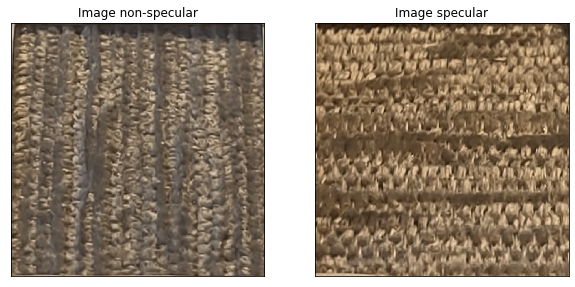

ORIGINAL STATS


,Max,Min,Mean,Variance,Skewness,Kurtosis,Directionality,Low frequencies,Middle frequencies,High frequencies,Mean chroma,Pattern strength,Pattern number,Colors number
Non-specular,76.33,19.75,43.33,143.49,0.65,0.44,0.55,2.319837e+11,1.183783e+11,6.892808e+09,503.92,3.52,2.0,1.0
Specular,81.55,16.48,46.61,228.58,0.32,-0.46,0.60,3.390894e+11,1.990174e+11,8.997702e+09,958.19,4.00,1.0,1.0


NORMALIZED STATS


,Max,Min,Mean,Variance,Skewness,Kurtosis,Directionality,Low frequencies,Middle frequencies,High frequencies,Mean chroma,Pattern strength,Pattern number,Colors number
Non-specular,1.01,-0.26,0.26,1.16,-0.06,-0.17,-0.03,0.40,1.52,0.49,-0.43,-0.32,1.19,-0.27
Specular,0.22,-0.74,-0.34,0.81,0.10,-0.08,0.05,0.25,1.31,-0.13,-0.15,-0.16,-0.54,-0.29


PREDICTIONS & RATINGS


,Color vibrancy,Surface roughness,Pattern complexity,Striped pattern,Checkered pattern,Brightness,Shininess,Sparkle,Hardness,Movement effect,Scale of pattern,Naturalness,Thickness,Multicolored,Value,Warmth
Output,-0.2587,0.4542,0.2485,0.3358,0.6946,-0.3144,-0.5954,-0.3771,-0.7988,-0.6427,0.6657,-0.1349,0.8455,-0.1187,-0.106,0.9019


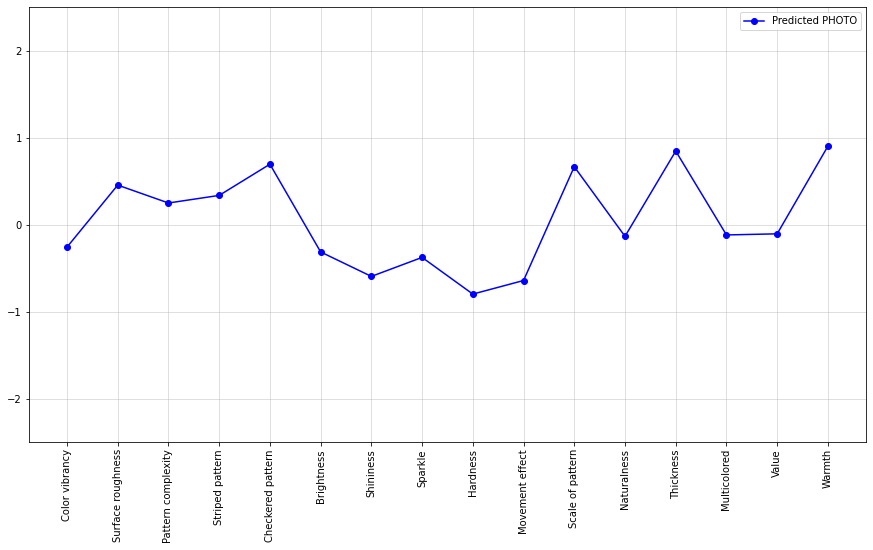

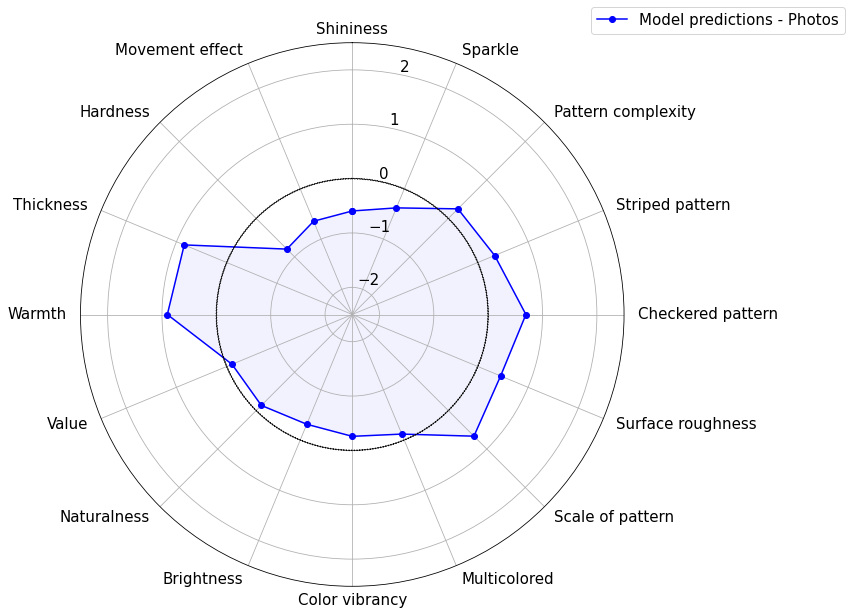

In [154]:
# path_1 = "../photo/mat01_0.jpg"
# image_1 = open_vid_image(path_1)
# image_1 = image_1[2035:2390, 1260:1635]

# path_2 = "../photo/mat01_1.jpg"
# image_2 = open_vid_image(path_2)
# image_2 = image_2[2020:2355, 1235:1645]

# res = predict_ratings_changed_photo(image_1, image_2)
# plot_res([res["PREDICT_RATINGS"]], colors=["blue"], labels=["Predicted PHOTO"])
# polar_plot([res["PREDICT_RATINGS"]], 
#            RATING_NAMES, ["blue"], 
#            LABELS=["Model predictions - Photos"],
#            order=RATING_CHANGE)

VIDEO


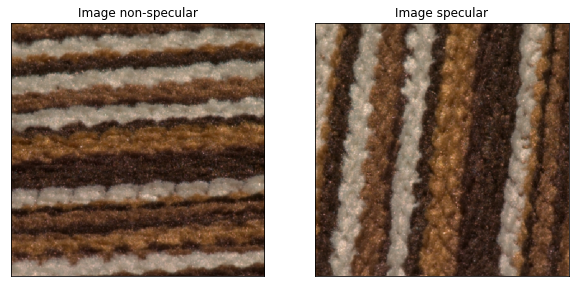

ORIGINAL STATS


,Max,Min,Mean,Variance,Skewness,Kurtosis,Directionality,Low frequencies,Middle frequencies,High frequencies,Mean chroma,Pattern strength,Pattern number,Colors number
Non-specular,70.05,5.98,34.70,320.24,0.31,-1.06,0.83,1.877796e+12,1.143336e+11,4.000667e+09,614.10,32.91,1.0,2.0
Specular,73.17,6.72,34.22,331.31,0.44,-0.91,0.84,1.936586e+12,1.144225e+11,4.692403e+09,627.02,23.97,1.0,2.0


NORMALIZED STATS


,Max,Min,Mean,Variance,Skewness,Kurtosis,Directionality,Low frequencies,Middle frequencies,High frequencies,Mean chroma,Pattern strength,Pattern number,Colors number
Non-specular,0.72,-0.91,-0.15,3.57,-0.18,-0.18,1.28,6.17,1.44,-0.04,-0.29,2.69,-0.62,2.16
Specular,-0.21,-1.14,-0.88,1.58,0.12,-0.08,1.29,3.44,0.39,-0.39,-0.54,0.52,-0.54,1.77


PREDICTIONS & RATINGS


,Color vibrancy,Surface roughness,Pattern complexity,Striped pattern,Checkered pattern,Brightness,Shininess,Sparkle,Hardness,Movement effect,Scale of pattern,Naturalness,Thickness,Multicolored,Value,Warmth
Output,-0.3827,0.1001,0.3130,1.2144,0.179,-0.4875,-0.8839,-0.5667,-0.7205,-0.8962,0.9135,-0.0408,0.6959,0.4416,0.0519,0.9248
Ratings,-0.3121,0.1596,0.2609,2.1453,0.482,-0.9802,-0.7739,-0.3533,-1.1343,-0.8839,0.9034,-0.3549,0.8830,0.7398,-0.1429,1.1274


CPU times: user 22.9 s, sys: 310 ms, total: 23.2 s
Wall time: 22.5 s


In [93]:
# %%time
# WHAT = "video"
# MATERIAL = 37
# print("VIDEO")
# res = predict_ratings_changed(MATERIAL, WHAT, PRINT=True)

VIDEO


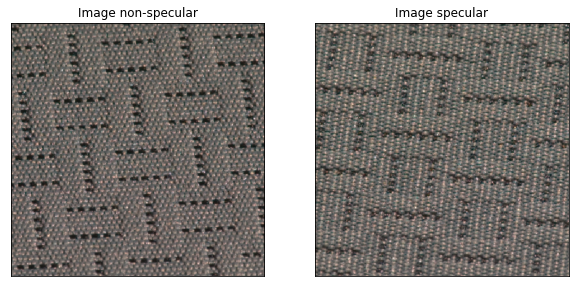

BTF


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


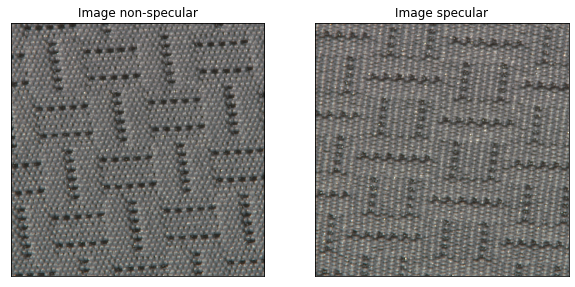

In [94]:
# # Open image
# print("VIDEO")
# WHAT = "video"
# MATERIAL = 23
# res = predict_ratings_changed(MATERIAL, WHAT, IMAGE=True, PRINT=False)
# # Open image
# print("BTF")
# WHAT = "EXR"
# MATERIAL = 23
# res = predict_ratings_changed(MATERIAL, WHAT, DPI=1070.86, IMAGE=True, PRINT=False)

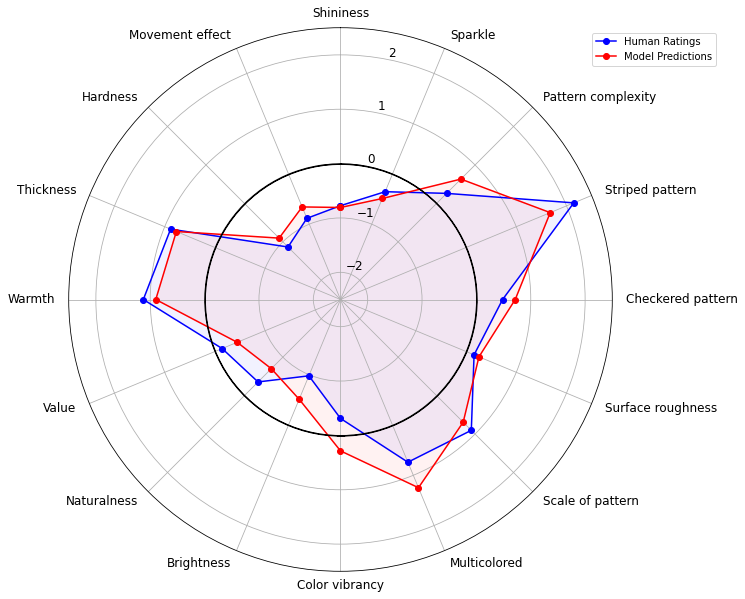

In [56]:
# polar_plot([res["ORIGINAL_RATINGS"], res["PREDICT_RATINGS"]], RATING_NAMES, ["blue", "red"], ["Human Ratings", "Model Predictions"], order=RATING_CHANGE)

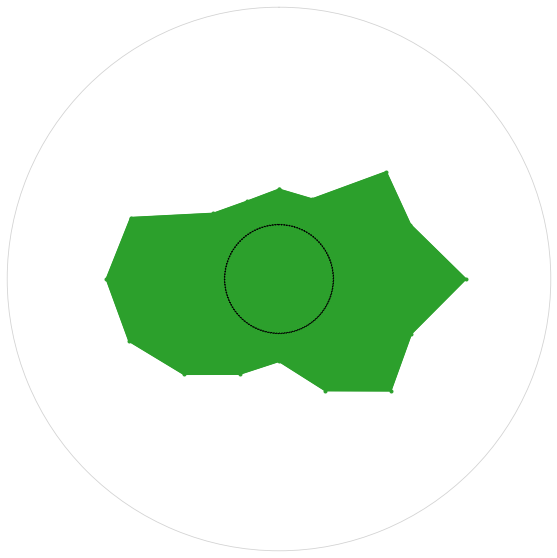

In [91]:
# polar_plot_trans([res["PREDICT_RATINGS"]], RATING_NAMES, ["tab:green"], 
#                 order=RATING_CHANGE, noticks=True,)

## Notes

In [42]:
# print(np.array2string(stats, formatter={'float_kind':'{0:.8f}'.format}))

# MIN = np.amin([*miss_vid, *miss_exr])
# if MIN < 0:
#     plt.ylim(MIN*1.6, np.amax([*miss_vid, *miss_exr])*1.5)
# else:
#     plt.ylim(MIN*0.8, np.amax([*miss_vid, *miss_exr])*1.5)

# ax.set_xticklabels(range(0, len(RATINGS)), fontsize=20)

# MAT_NAMES = ['fabric', 'wood', 'paper', 'coating', 'plastic', 'leather', 'metal', 'carpet', 'ceramics', 
#              'glass', 'sand', 'soil', 'graphite', 'cork', 'stone']

# Some material's names match BTF folders, wood has additional name, some are not measured

# MODEL_PARAM_1 = './modelParams347_norm1_tr279te068_mean1'
# MODEL_PARAM_1 = './modelParams347_norm1_tr279te068_mean0''
# MODEL_PARAM_1 = './modelParams347_norm1_tr279te068_mean1_stat512'
# MODEL_PARAM_1 = './modelParams347_norm1_tr279te068_mean2_stat512'

# file = './statsMeanStd_mean1.txt'
# file = './statsMeanStd_mean1_512.txt'
# file = './statsMeanStd_mean2.txt'

# BORDERS = [0, 5, 50, 128]